# Homework 2
Pablo González Tamames

## Exercise 1
Assume we have 1 dollar to be invested in two assets, whose return is modeled as a bivariate Gaussian distribution such that

$$
\Sigma = \begin{pmatrix}
0.25 & 0.15 \\ 0.15 & 0.10
\end{pmatrix}
$$

How much should we invest in each to minimize the overall variance in return with and without short selling? Answer this question solving the problem analytically and using a numerical code for constrained optimization problems. To simplify the problem, the acceptable baseline expected rate of return $m_b$ is $−\infty$.

### Analytical solution
In this problem we have to minimize the variance with inequality constrains. This variance is computed in the following way $f(\textbf{w}) = \textbf{w}^\top \Sigma\textbf{w}$ where each component of the vector $\textbf{w}$ is the weight that the corresponding asset is going to have in our portfolio.

#### With short selling

The constrains that we have to take into account are $\sum_i^nw_i=1$, this means that our weights must sum to 1. Now to solve the problem lets compute the function $f(\textbf{w})$.

$$
    f(\textbf{w}) = \begin{pmatrix} w_1 & w_2 \end{pmatrix} \begin{pmatrix} 0.25 & 0.15 \\ 0.15 & 0.10 \end{pmatrix}\begin{pmatrix} w_1 \\ w_2 \end{pmatrix}= 0.25 w_1^2+0.3w_1w_2+0.1w_2^2=f(w_1,w_2).
$$

With this function we have to solve a optimization problem in two dimensions but we can transform it by taking into account the constrain $w_1+w_2=1\to w_1=1-w_2$. So if we substitute this in the original equation we get $f(w_2) = 0.05w_2^2-0.2w_2+0.25,$ that is a function of only one variable so to find its minimum we just have to derive it.

$$
f'(w_2) = 0.1w_2-0.2.
$$

And the minimum is achieved at $0.1w_2 = 0.2\to w_2 = 2$. With this value of $w_2$ we get $w_1=-1$ and the solution is:

$$
    \textbf{w} = \begin{pmatrix}-1\\2\end{pmatrix}.
$$

With this solution we see that we have to short sell the first asset and then buy the second one.

#### Without short selling
In this case we don't allow the weights to be negative, but the rest of the problem is the same. We have to implement the following constrains $w_1\geq0$ and $w_2\geq0$. Because $w_2$ is positive and $w_1=1-w_2$ is also positive we have that $w_2$ must be also less or equal than 1, so $w_2\in[0,1]$. The absolute minimum from of the function $f(w_2)$, obtained in [the previous section](#with-short-selling), is not inside this region so because we know that this function only has an extrema point the minimum value inside the interval must be achieved at the boundaries.

$$
f(0) = 0.25 \;\;\;\text{and}\;\;\; f(1) = 0.1
$$

So the minimum is at $w_2=1$ therefore $w_1$ must be 0.

$$
    \textbf{w} = \begin{pmatrix}0\\1\end{pmatrix}.
$$

## Numeric solution
To find a numerical solution we are going to implement something similar to the Newton method that we use for the previous assignment. In order for the Newton method to work with equality constrains we have to choose as a starting point a feasible one and we have to redefine the step of the Newton method.

First we are going to define some functions that we are going to use, as the function itself, the gradient and the line search method. 

In [1]:
import numpy as np
import numpy.linalg as npl
from copy import copy

def f(w):
    return 0.25*w[0]**2 + 0.30*w[0]*w[1] + 0.1*w[1]**2

def gradient(w):
    return np.array([0.5*w[0] + 0.3*w[1], 0.3*w[0] + 0.2*w[1]])

def line_search(d_k, x, t=1.0):
    """Implement the line search method, this function update the time step
    until the criterion is fulfilled"""

    alpha = 0.01
    beta = 0.5
    while f(x + t*d_k) > f(x) + alpha*t*np.dot(gradient(x),d_k):
        t *= beta
    return t

As in the previous assignment we need to compute the Hessian matrix, in this case this matrix is:

$$
H = \begin{pmatrix}
\partial^2_{w_1}f & \partial_{w_1}\partial_{w_2}f \\
\partial_{w_1}\partial_{w_2}f & \partial^2_{w_2}f
\end{pmatrix} = \begin{pmatrix}
0.5 & 0.3 \\ 0.3 & 0.2
\end{pmatrix} = \nabla^2f
$$

We have to redefine the step of this method and to do so we need to solve a different system that the one on the previous assignment. In this case the system that we have to solve is:

$$
\begin{bmatrix}
\nabla^2f & A^\top \\ A & 0
\end{bmatrix}
\begin{bmatrix} d_k \\ \lambda_k \end{bmatrix}
=
\begin{bmatrix} -\nabla f \\ 0 \end{bmatrix},
$$

where $A = \begin{pmatrix} 1 & 1 \end{pmatrix}$, is the matrix that gives us the constrain $A\text{w}=1$.

Now lets put the code for the newton method. In both cases we use as a starting point $\begin{pmatrix}0.5 & 0.5\end{pmatrix}$ because is a feasible point.

In [2]:
HESSIAN = np.array([[0.5, 0.3], [0.3, 0.2]])
A = np.array([[1.0, 1.0]])
# Define the matrix above
MATRIX = np.zeros((3, 3))
MATRIX[:2,:2] = HESSIAN
MATRIX[:2,-1:] = A.T
MATRIX[-1:,:2] = A

def newtons_method_1(stop, x, short_selling = False, iterations=1000, stopping_2 = [-5.0, -5.0], debug=True):
    """Implementation of the newton method"""

    grad = gradient(x)
    if np.dot(grad, grad) < stop**2:  # check the case that we are already in a minimum
        return x, 0

    for ite in range(1,iterations):
        g = gradient(x)
        lhs = np.concatenate((-g.T,[0])).reshape((3,1))
        solution = npl.solve(MATRIX, lhs)
        descend_direction = solution[:2].reshape((2,))
        
        if short_selling:
            crit = np.dot(g, descend_direction)
            if np.abs(crit) < stop:
                return x, ite
            t = line_search(descend_direction, x)
            x = x + t * descend_direction
        else:
            t = 1
            while min(x + t*descend_direction) < 0:
                t *= 0.5
            t = line_search(descend_direction, x, t)
            x_prev = copy(x)
            x = x + t*descend_direction
            if all(x_prev - x <= stopping_2):
                return x, ite


    if debug:
        print(f"The stop criterion wasn't achieve in {iterations} iterations.")
    return x, ite

### With short selling
In this case the solution $\textbf{w}$ could have negative values. We implement a line search method with parameters $\alpha=0.01$, $\beta=0.5$ and initial `t`=1. As a stopping criterion we compute the dot product of the gradient and the descend direction, if the absolute value of this is smaller than the tolerance we stop the method.  

In [3]:
point, iterations = newtons_method_1(1.0e-05, [0.5,0.5], short_selling=True)
print(f"The minimum is achieve at {point} with {iterations} iterations")

The minimum is achieve at [-1.  2.] with 2 iterations


We see that we get the expected point for the minimum with a small number of iterations

### Without short selling
Now, we can't have negative values for the weights. In this case what we do is check if, with our value of `t`, if the next point satisfy our conditions if it doesn't we decrease the value ot `t` until it does. In other words, what we do is compute $x+t_kd_k$ where $x$ is our vector $\textbf{w}$, if one of the components of this vector is smaller than 0 we decrease the value of `t` and check again. In this case the stopping criterion isn't valid because we are not aiming for the absolute minimum so the product of the descend direction and the gradient can be something big, therefore we have to implement another way of stopping the method. The number of iterations can work as our criterion.

In [4]:
point, iterations = newtons_method_1(1.0e-05, [0.5,0.5], short_selling=False)
print(f"The minimum is achieve at {point} with {iterations} iterations")

The stop criterion wasn't achieve in 1000 iterations.
The minimum is achieve at [0. 1.] with 999 iterations


We get the desire point but probably what is happening is that we achieve that point early in the simulation but because the gradient is not small enough the stop criterion is not satisfy and the programme continues until we run out of iterations. To avoid this we can implement another stop criterion. Because we'll reach the minimum after some iterations we can check de difference between one point and the previous one, after some iterations this difference will be small enough (even we can aim to do this difference 0).

In [5]:
stop = 1.0e-05
point, iterations = newtons_method_1(stop, [0.5,0.5], short_selling=False, stopping_2=[stop, stop])
print(f"The minimum is achieve at {point} with {iterations} iterations")

The minimum is achieve at [9.17898810e-07 9.99999082e-01] with 10 iterations


If we use the same stopping criterion for both cases ($10^{-5}$) we see that we get an approximate solution with very few steps.

We can get a more strict condition, for example ($10^{-10}$).

In [6]:
stop = 1.0e-10
point, iterations = newtons_method_1(stop, [0.5,0.5], short_selling=False, stopping_2=[stop, stop])
print(f"The minimum is achieve at {point} with {iterations} iterations")

The minimum is achieve at [2.16330086e-11 1.00000000e+00] with 19 iterations


With only a few more steps we get a much better solution. We can try for perfection and set that the difference must be 0 for the programme to stop.

In [7]:
stop = 0.0
point, iterations = newtons_method_1(stop, [0.5,0.5], short_selling=False, stopping_2=[stop, stop])
print(f"The minimum is achieve at {point} with {iterations} iterations")

The minimum is achieve at [0. 1.] with 529 iterations


### Comparison
Now we can compare the execution times of all the cases

With short selling:

In [8]:
%%timeit
newtons_method_1(1.0e-05, [0.5,0.5], short_selling=True)

58.8 µs ± 3.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Without short selling and iterations as stopping criterion:

In [9]:
%%timeit
newtons_method_1(1.0e-05, [0.5,0.5], short_selling=False, debug=False)

2.49 s ± 73.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Without short selling and difference of $10^{-05}$ as stopping criterion:

In [10]:
%%timeit
stop = 1.0e-05
newtons_method_1(stop, [0.5,0.5], short_selling=False, stopping_2=[stop, stop])

703 µs ± 22.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Without short selling and difference of $10^{-10}$ as stopping criterion:

In [11]:
%%timeit
stop = 1.0e-10
newtons_method_1(stop, [0.5,0.5], short_selling=False, stopping_2=[stop, stop])

1.86 ms ± 58.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Without short selling and difference of 0 as stopping criterion:

In [12]:
%%timeit
stop = 0.0
newtons_method_1(stop, [0.5,0.5], short_selling=False, stopping_2=[stop, stop])

946 ms ± 57.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can see that the fastest one is the one with short selling because we get there in only 2 iterations. Between the others it's clear that the ones with smaller iterations are faster.

## Exercise 2

In this case what we have to solve is the problem

$$
\begin{matrix} 
\text{max} & m^\top w-\kappa w^\top \Sigma w \\
\text{subject to} & \sum_i^n w_i = 1 \\
 & w_i\geq 0
\end{matrix}
$$

But we know how to solve a minimization problem, so we have to change it. To do so we just need to multiply the function by -1 so the problem is:

$$
\begin{matrix} 
\text{min} & -m^\top w+\kappa w^\top \Sigma w \\
\text{subject to} & \sum_i^n w_i = 1 \\
 & w_i\geq 0
\end{matrix}
$$

### Solution

To gey rid of the inequality constrains we are going to use a logarithmic barrier. As we know the logarithmic barrier is an approximation of the indicator function and the function that we need is 

$$
-\frac{1}{t}\sum_i^n\log{f_i(w)}.
$$

Where $f_i$ are the functions that give us the inequality constrains, in our case all this functions are the identity. So our transform problem is the following

$$
\begin{matrix} 
\text{min} & -m^\top w+\kappa w^\top \Sigma w -p \sum_i^n\log{w_i} \\
\text{subject to} & \sum_i^n w_i = 1
\end{matrix}
$$
where $p$ is our parameter, that we are going to set at $p=0.001$.

The first thing is to work with the matrix A and extract the correlation matrix for each column of A. For this we are going to use a function implemented in python. We also need the mean values for every stock.

In [13]:
A = np.array(
    [
        [1973, 1.075, 0.942, 0.852, 0.815, 0.698, 1.023, 0.851, 1.677],
        [1974, 1.084, 1.020, 0.735, 0.716, 0.662, 1.002, 0.768, 1.722],
        [1975, 1.061, 1.056, 1.371, 1.385, 1.318, 1.123, 1.354, 0.760],
        [1976, 1.052, 1.175, 1.236, 1.266, 1.280, 1.156, 1.025, 0.960],
        [1977, 1.055, 1.002, 0.926, 0.974, 1.093, 1.030, 1.181, 1.200],
        [1978, 1.077, 0.982, 1.064, 1.093, 1.146, 1.012, 1.326, 1.295],
        [1979, 1.109, 0.978, 1.184, 1.256, 1.307, 1.023, 1.048, 2.212],
        [1980, 1.127, 0.947, 1.323, 1.337, 1.367, 1.031, 1.226, 1.296],
        [1981, 1.156, 1.003, 0.949, 0.963, 0.990, 1.073, 0.977, 0.688],
        [1982, 1.117, 1.465, 1.215, 1.187, 1.213, 1.311, 0.981, 1.084],
        [1983, 1.092, 0.985, 1.224, 1.235, 1.217, 1.080, 1.237, 0.872],
        [1984, 1.103, 1.159, 1.061, 1.030, 0.903, 1.150, 1.074, 0.825],
        [1985, 1.080, 1.366, 1.316, 1.326, 1.333, 1.213, 1.562, 1.006],
        [1986, 1.063, 1.309, 1.186, 1.161, 1.086, 1.156, 1.694, 1.216],
        [1987, 1.061, 0.925, 1.052, 1.023, 0.959, 1.023, 1.246, 1.244],
        [1988, 1.071, 1.086, 1.165, 1.179, 1.165, 1.076, 1.283, 0.861],
        [1989, 1.087, 1.212, 1.316, 1.292, 1.204, 1.142, 1.105, 0.977],
        [1990, 1.080, 1.054, 0.968, 0.938, 0.830, 1.083, 0.766, 0.922],
        [1991, 1.057, 1.193, 1.304, 1.342, 1.594, 1.161, 1.121, 0.958],
        [1992, 1.036, 1.079, 1.076, 1.090, 1.174, 1.076, 0.878, 0.926],
        [1993, 1.031, 1.217, 1.100, 1.113, 1.162, 1.110, 1.326, 1.146],
        [1994, 1.045, 0.889, 1.012, 0.999, 0.968, 0.965, 1.078, 0.990],
    ]
)
A = A[:,1:]  # Delete the year column

SIGMA = np.corrcoef(A.T)

MEANS = np.mean(A, axis=0).reshape((8,1))


Once we have our matrix $\Sigma$ and the vector of means $m$ we can define the functions that we are going to use. The function that we want to minimize is the first one, then the gradient that is:

$$
\nabla f = -m + 2\kappa\Sigma w - p\frac{1}{w}
$$
note that the return of this function is a vector. And the Hessian:
$$
\nabla^2 f = 2\kappa\Sigma+p\left(\frac{1}{w}\right)^2
$$
where the term $\left(\frac{1}{w}\right)^2$ is a matrix whose diagonal entries are the entries of the vector. This function returns a matrix.

In [14]:
def f_2(w, k, param):
    """The function with logarithmic barrier"""
    return (-MEANS.T@w + k*w.T@SIGMA@w - param*np.sum(np.log(w))).reshape(1)


def gradient_2(w, k, param):
    """The gradient is a vector"""
    return -MEANS + 2*k*SIGMA@w - param*np.reciprocal(w)


def hessian(w, k, param):
    """The Hessian is a matrix"""
    return 2*k*SIGMA + param*np.diag(np.reciprocal(w)**2) 

Now we implement the Newton method again. As before we need to solve the KKT system that is define in the following way:

$$
\begin{bmatrix}
\nabla^2f & \nabla g^\top \\ \nabla g & 0
\end{bmatrix}
\begin{bmatrix} d_k \\ \lambda_k \end{bmatrix}
=
\begin{bmatrix} -\nabla f \\ -g \end{bmatrix},
$$

where $g$ is the function that gives us the equality constrain so $\sum_i^nw_i-1=0$, the gradient of this function is a a vector of 1. Our KKT system looks like this:

$$
\begin{bmatrix}
\nabla^2f & \textbf{1}^\top \\ \textbf{1} & 0
\end{bmatrix}
\begin{bmatrix} d_k \\ \lambda_k \end{bmatrix}
=
\begin{bmatrix} -\nabla f \\ 0 \end{bmatrix}.
$$

Because in this case our Hessian matrix depend on the point we have to define it every step of our method. In this case the stopping criterion is the number of iterations.


In [15]:
def newtons_method_2(x, k, param):

    for ite in range(1000):
        g = gradient_2(x, k, param)
        matrix = np.zeros((9,9))
        matrix[:8,:8] = hessian(x, k, param)
        matrix[:8,-1:] = np.ones((8,1))
        matrix[-1:,:8] = np.ones((1,8))

        lhs = np.concatenate((-g, [[0]]))

        solution = npl.solve(matrix, lhs)
        descend_direction = solution[:8].reshape((8,1))
        fprime = g.T@descend_direction

        t = 1.0
        while np.min(x + t*descend_direction, axis=0) < 0:
            t *= 0.5
        while f_2(x + t*descend_direction, k, param) > f_2(x, k, param) + (0.01*t*fprime):
            t *= 0.5
        x = x + t*descend_direction

    return x, ite

For the starting point we are going tu use the point whose all components are the same and they sum up to 1. As we have said before we set $p=0.001$ and for this example $\kappa$ (the risk tolerance) is 0.001, so we accept a risky inversion.

In [16]:
x = np.ones(shape=(8,1))*(1/8)
k = 0.001
param = 0.001
w, _ = newtons_method_2(x, k,  param)
print(f"The weights are: {w}.")
print(f"And the maximum value of our function is {-f_2(w, 0.0001,  0.00001 )}")

The weights are: [[0.01691119]
 [0.02134495]
 [0.0486751 ]
 [0.05944633]
 [0.05397605]
 [0.02089261]
 [0.63778204]
 [0.14097174]].
And the maximum value of our function is [1.13291801]


### Plots

In this case we are plotting the return of the portfolio with different values of the risk tolerance, we can see that as we increase the risk tolerance parameter (we decrease the risk) the outcome is lower, but note that the lower value is not 1 so we have some return minimizing the risk.

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

param = 0.001
x_ini = np.ones(shape=(8,1))*(1/8)
solutions = []
x = []
for k in np.linspace(0.0001,1,100):
    w, _ = newtons_method_2(x_ini, k, param)
    solutions.append((MEANS.T@w).reshape(1))
    x.append((w.T@SIGMA@w).reshape(1))

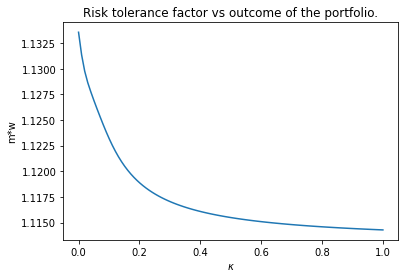

In [18]:
plt.plot(np.linspace(0.0001,1,100), solutions)
plt.title("Risk tolerance factor vs outcome of the portfolio.")
plt.xlabel("$\\kappa$")
plt.ylabel("m*w")
plt.show()

In the second plot we can see how as we increase the risk we also increase the return of our portfolio. This is the efficient frontier.

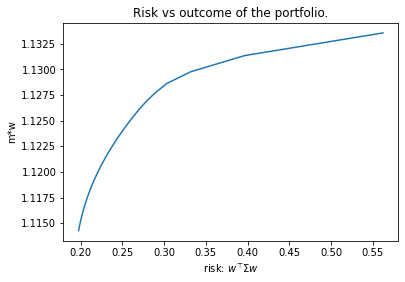

In [19]:
plt.plot(x, solutions)
plt.title("Risk vs outcome of the portfolio.")
plt.xlabel("risk: $w^\\top\\Sigma w$")
plt.ylabel("m*w")
plt.show()